# MIMIQ demo - GHZ state including dynamic circuits
QPerfect 2025 https://qperfect.io/

The interactive version of this demo can be found at https://github.com/qperfect-io/MimiqDemos/blob/main/GHZ/ghz.ipynb

## Introduction and context
The Greenberger-Horne-Zeilinger (GHZ) state represents a maximally entangled state of three or more qubits. The GHZ state is typically represented for three qubits as $\frac{1}{\sqrt{2}}(∣000\rangle+∣111\rangle)$. This state exemplifies notions of non-local correlations and violation of classical inequalities, and can be used to achieve enhanced performance for quantum sensing compared to non-entangled input states.

GHZ state preparation has also become an important benchmark for quantum computers, demonstrating their ability to create and manipulate complex entangled states on larger and larger scales. In 2024, Quantinuum reported the largest GHZ state ever produced on a quantum computer with 50 qubits.

In this demo, we'll use MIMIQ to explore and compare three different methods for implementing GHZ state preparation on quantum computers, simulating them exactly up to 50 qubits. We will demonstrate how to add and characterize noise in quantum circuits, and show how different circuit implementations can give drastically different performance on real quantum hardware.

This demonstration builds on a recent [blog post](https://egrettathula.wordpress.com/2024/03/24/efficient-circuit-for-ghz-state-preparation).

### MIMIQ Features used in this demo
- Noise models
- Midcircuit measurements
- If statements (conditional classical logic)

## MIMIQ implementation

Let's begin by importing the necessary packages and establishing a connection to the MIMIQ service.

In [22]:
from mimiqcircuits import *
from mimiqcircuits.visualization import *
import matplotlib.pyplot as plt
import random
import numpy as np
from time import sleep

# create a connection to the MIMIQ server
conn = MimiqConnection()
conn.connect()

Connection:
├── url: https://mimiq.qperfect.io/api
├── Computing time: 6164/10000 minutes
├── Executions: 8153/10000
├── Max time limit per request: 240 minutes
├── Default time limit is equal to max time limit: 240 minutes
└── status: open

We'll start by setting up some parameters for our experiments.

In [427]:
nqubits = 8

# plotting parameters
plt.rcParams['figure.figsize'] = (4,2)
plt.rcParams['font.size'] = 8

### Linear Depth Circuit Construction

For our first example we will build a textbook implementation of the GHZ circuit. This consists of a Hadamard operation on one of the qubits followed by a cascade of CNOT gates. 

Here's how we implement this as a MIMIQ circuit:

In [428]:
def ghz_linear_depth(nqubits):
    circ = Circuit()
    circ.push(GateH(), 0)
    circ.push(GateCX(), range(0,nqubits), range(1,nqubits))
    return circ

In [429]:
circ = ghz_linear_depth(nqubits)
circ.draw()

        ┌─┐                                                                     
 q[0]: ╶┤H├─●──────────────────────────────────────────────────────────────────╴
        └─┘┌┴┐                                                                  
 q[1]: ╶───┤X├─●───────────────────────────────────────────────────────────────╴
           └─┘┌┴┐                                                               
 q[2]: ╶──────┤X├─●────────────────────────────────────────────────────────────╴
              └─┘┌┴┐                                                            
 q[3]: ╶─────────┤X├─●─────────────────────────────────────────────────────────╴
                 └─┘┌┴┐                                                         
 q[4]: ╶────────────┤X├─●──────────────────────────────────────────────────────╴
                    └─┘┌┴┐                                                      
 q[5]: ╶───────────────┤X├─●───────────────────────────────────────────────────╴
                       └─┘┌┴

Now let's execute it and observe the statistical distribution of outputs:

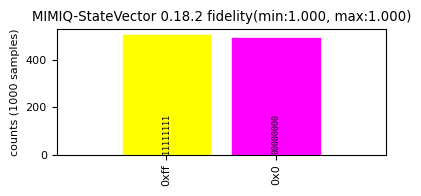

In [430]:
job = conn.execute(circ)
res = conn.get_result(job)
plothistogram(res, mimiqstyle=False)

As expected, we see that the output states are predominantly $|111\ldots1\rangle$ or $|000\ldots 0\rangle$ with roughly equal probabilities. This is consistent with the GHZ state $\frac{1}{\sqrt{2}}\left(|000\ldots 0\rangle + |111\ldots1\rangle\right)$. The slight deviation from exactly 50% probability for each state is due to the nature of random sampling.

### Logarithmic depth implementation

While the linear depth implementation is straightforward, it's not always optimal for real quantum computers. The sequential application of CNOT gates results in significant idle time where errors can accumulate. Moreover, some quantum hardware may prefer nearest-neighbor interactions.

An alternative implementation proposed by [Cruz et al., 2019](https://onlinelibrary.wiley.com/doi/10.1002/qute.201900015) generates the GHZ state in logarithmic depth using long-range gates:

In [431]:
def ghz_log_depth(nqubits):
    circ = Circuit()
    circ.push(GateH(), 0)
 
    l = int(np.ceil(np.log2(nqubits)))
    for m in range(l, 0, -1):
        for k in range(0, nqubits, 2 ** m):
            if k + 2 ** (m - 1) >= nqubits:
                continue
            circ.push(GateCX(), k, k + 2 ** (m - 1))
    return circ

In [432]:
circ = ghz_log_depth(nqubits)
circ.draw()

        ┌─┐                                                                     
 q[0]: ╶┤H├─●──●─────●─────────────────────────────────────────────────────────╴
        └─┘ │  │    ┌┴┐                                                         
 q[1]: ╶────┼──┼────┤X├────────────────────────────────────────────────────────╴
            │ ┌┴┐   └─┘                                                         
 q[2]: ╶────┼─┤X├───────●──────────────────────────────────────────────────────╴
            │ └─┘      ┌┴┐                                                      
 q[3]: ╶────┼──────────┤X├─────────────────────────────────────────────────────╴
           ┌┴┐         └─┘                                                      
 q[4]: ╶───┤X├────●────────●───────────────────────────────────────────────────╴
           └─┘    │       ┌┴┐                                                   
 q[5]: ╶──────────┼───────┤X├──────────────────────────────────────────────────╴
                 ┌┴┐      └─

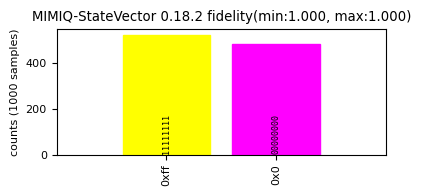

In [433]:
job = conn.execute(circ)
res = conn.get_result(job)
plothistogram(res, mimiqstyle=False)

The results are identical to before. The choice between linear and logarithmic depth circuits depends on the specific quantum hardware. In the following sections, we'll use MIMIQ to assess the relative merits of each implementation by studying the influence of gate errors on large-scale GHZ state preparations.

## Going further with MIMIQ

MIMIQ offers several advantages over physical quantum computers for our study:
1. No connectivity limitations between qubits
2. Exact simulations at large scales (depending on entanglement)
3. Efficient Matrix Product State (MPS) representation of GHZ states

These features allow us to simulate GHZ circuits with hundreds or even thousands of qubits, making MIMIQ ideal for benchmarking algorithms for real quantum computers.

In the following sections, we'll demonstrate how to efficiently generate GHZ states with 50 qubits and study the influence of gate errors and idle time errors using MIMIQ's noisy simulation capabilities.

First lets set up some new parameters:

### Adding Noise To Simulations

MIMIQ allows us to add errors and noise to simulations using the Kraus operator representation, simulated via quantum trajectories. We can add individual noise terms to circuits or apply noise channels to all gates of a specific type. MIMIQ supports arbitrary one- and two-qubit noise channels, with common types (e.g., Pauli errors, depolarizing noise, amplitude damping) predefined for convenience.

To model noise accurately, we'll modify our GHZ circuits to include explicit identity gates representing idle periods. We assume gates acting on disjoint qubit sets can operate in parallel, minimizing idle periods.

In [434]:
# Linear depth circuit
def ghz_linear_depth_with_idle(nqubits):
    """
    Construct a GHZ state preparation circuit with linear depth, including idle qubit operations.
    """
    def all_except(*q):
        """ return all qubit indices except those specified as arguments """
        return [j for j in range(nqubits) if j not in q]
    
    circ = Circuit()
    
    # Apply Hadamard to qubit 0 and identity to all others
    circ.push(GateH(), 0)
    circ.push(GateID(), all_except(0))
    
    # Apply CNOT gates and identity gates
    for i in range(nqubits - 1):
        circ.push(GateCX(), i, i+1)
        circ.push(GateID(), all_except(i,i+1))

    circ.push(Measure(), range(nqubits), range(nqubits))
    return circ

# log depth GHZ circuit
def ghz_log_depth_with_idle(nqubits):
    """
    Construct a GHZ state preparation circuit with logarithmic depth, including idle qubit operations.
    """
    def all_except(*q):
        """ return all qubit indices except those specified as arguments """
        return [j for j in range(nqubits) if j not in q]
    
    circ = Circuit()
    
    # Apply Hadamard to qubit 0 and identity to all others
    circ.push(GateH(), 0)
    circ.push(GateID(), all_except(0))
 
    l = int(np.ceil(np.log2(nqubits)))
    for m in range(l, 0, -1):
        active_qubits = []
        for k in range(0, nqubits, 2 ** m):
            if k + 2 ** (m - 1) >= nqubits:
                continue
            circ.push(GateCX(), k, k + 2 ** (m - 1))
            active_qubits.extend([k, k + 2 ** (m - 1)])
        
        # Apply identity gates to all idle qubits in this step
        circ.push(GateID(), all_except(*active_qubits))

    circ.push(Measure(), range(nqubits), range(nqubits))
    return circ

Now, let's construct our circuit and use MIMIQ's built-in methods to add depolarizing noise to each idle gate and CNOT gate. We'll start with a 50-qubit implementation:

In [435]:
# simulation parameters
noise_ampl = 0.01
nqubits = 50
nsamples = 100

plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 12

### Linear depth circuit with noise

Number of Kraus operators in circuit:  2450


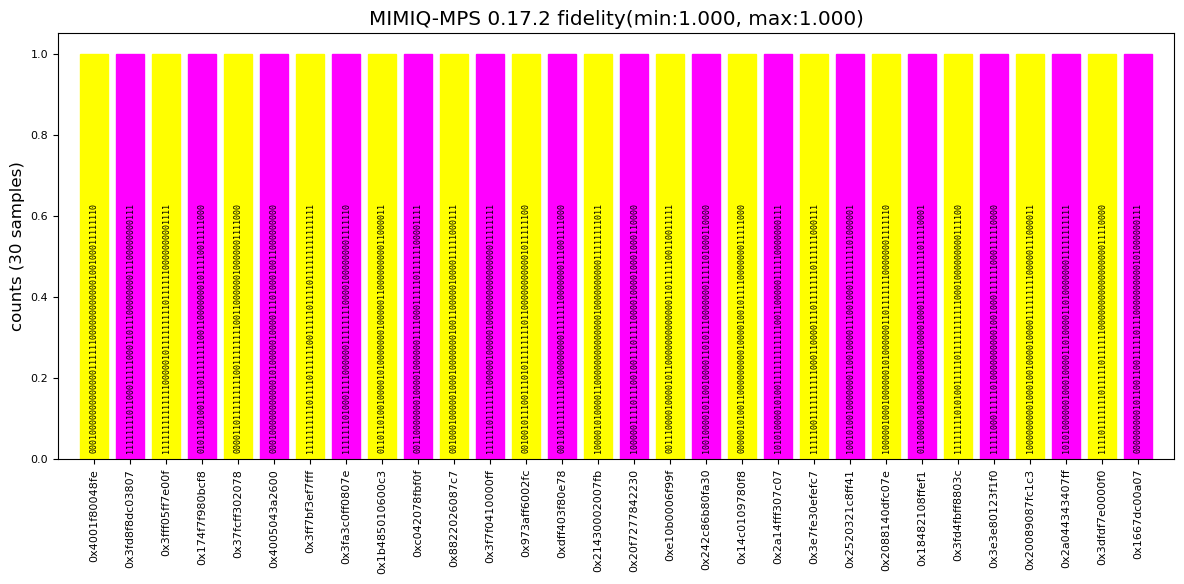

In [436]:
# build the circuit and add noise
circ = ghz_linear_depth_with_idle(nqubits)
circ.add_noise(GateID(), Depolarizing1(noise_ampl))
circ.add_noise(GateCX(), Depolarizing2(noise_ampl))

# count the number of Kraus operators
nk = sum(isinstance(c.get_operation(), krauschannel) for c in circ)

# execute
job = conn.execute(circ, nsamples=nsamples)
res = conn.get_result(job)

# output the results
print("Number of Kraus operators in circuit: ", nk)
plothistogram(res, num_outcomes=30, mimiqstyle=False)

Ouch! that's not good. The output now is mostly noise, with very few samples expected for a GHZ state. This is understandable, as small depolarizing errors accumulate during the many idle periods.

Let's compare this with the logarithmic depth circuit:

Number of Kraus operators in circuit:  300


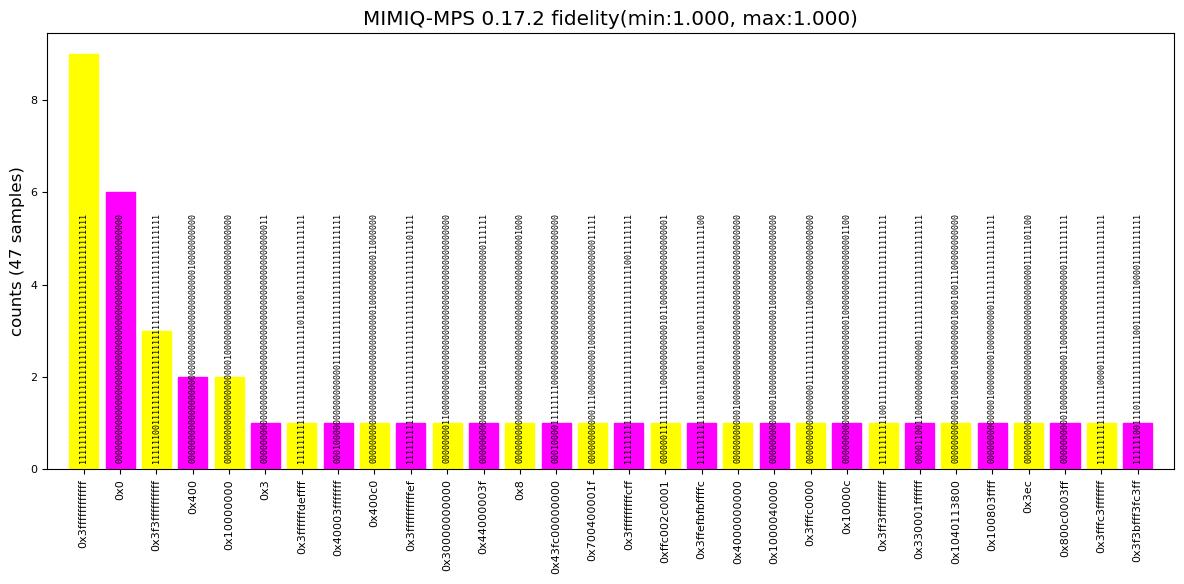

In [437]:
# build the circuit and add noise
circ = ghz_log_depth_with_idle(nqubits)
circ.add_noise(GateID(), Depolarizing1(noise_ampl))
circ.add_noise(GateCX(), Depolarizing2(noise_ampl))

# count the number of Kraus operators
nk = sum(isinstance(c.get_operation(), krauschannel) for c in circ)

# execute the simulation
job = conn.execute(circ, nsamples=nsamples)
res = conn.get_result(job)

# output the results
print("Number of Kraus operators in circuit: ", nk)
plothistogram(res, num_outcomes=30, mimiqstyle=False)

This shows a big improvement! The two GHZ states are now the most probable outcomes, although they still only represent about 15% of all outcomes. Can we do better? Absolutely!

### Dynamic Circuits: Constant-Depth GHZ Circuit

While the logarithmic depth circuit is optimal for unitary gates, GHZ states can be prepared by a constant-depth quantum circuit using mid-circuit measurements, classical feedback, and classical computation ([Quek, Kaur, Wilde, 2022](https://arxiv.org/pdf/2206.15405), [Bäumer et al., 2024](https://arxiv.org/abs/2308.13065)) as depicted below:

![](ghz_files/ghz-constant-depth-i.png)

This implementation is remarkable in that it allows to prepare an $N$-qubit GHZ state with a constant depth circuit (independent of $N$). MIMIQ readily supports such dynamic circuits, so let's find out how it works.

First, let's define a conditional XOR operation to flip a qubit's state based on one or more classical bits:

In [438]:
def xor(gate, target_qubit, *classical_bits):
    """
    Apply an operation on a target qubit based on the XOR of arbitrary classical bits.
    Uses a divide-and-conquer approach to minimize the number of operations.
    """
    circuit = Circuit()
    num_bits = len(classical_bits)
    
    if num_bits == 0:
        return circuit
    elif num_bits == 1:
        circuit.push(IfStatement(gate, BitString('1')), target_qubit, classical_bits[0])
    else:
        # Use a divide-and-conquer approach
        mid = num_bits // 2
        left_bits = classical_bits[:mid]
        right_bits = classical_bits[mid:]
        
        # Recursively apply XOR to left and right halves
        circuit.append(xor(gate, target_qubit, *left_bits))
        circuit.append(xor(gate, target_qubit, *right_bits))
    
    return circuit


Now we can define the dynamic circuit for GHZ state preparation, including identity gates on non-active qubits:

In [439]:
def ghz_dynamic_circuit_with_idle(nqubits):
    """
    Generate a GHZ state for an arbitrary number of qubits using dynamic circuits,
    including idle qubit operations.
    """
    def all_except(*q):
        return [j for j in range(nqubits) if j not in q]
    
    circuit = Circuit()
    
    # Step 1: Create initial superposition
    for q in range(nqubits):
        if q%2:
            circuit.push(GateID(), q)
        else:
            circuit.push(GateH(), q)
    
    # Step 2: Entangle all qubits
    for q in range(0,nqubits - 1,2):
        circuit.push(GateCX(), q, q+1)  
        
    for q in range(1,nqubits - 1,2):
        circuit.push(GateCX(), q+1, q) 
    
    # Step 3: Measure and apply conditional operations
    for m in range(1, nqubits-1, 2):
        circuit.push(Measure(), m, m-1)
        circuit.push(GateID(), m-1)
        
        if m + 1 < nqubits:
            circuit.append(xor(GateX(), m+1, *range(m)))
            circuit.push(GateID(), m)

    # Step 4: Reset measured qubits
    for q in range(nqubits):
        if q%2:
            circuit.push(Reset(), q)
        else:
            circuit.push(GateID(), q)
    
    # Step 5: Re-entangle qubits
    for q in range(0,nqubits-1,2):
        circuit.push(GateCX(), q, q+1)
    
    # Step 6: Final measurement
    circuit.push(Measure(), range(nqubits), range(nqubits))
    
    return circuit

Let's run this circuit. Note that it takes slightly longer than the unitary implementations since each sample corresponds to a new trajectory (but still only a few seconds for 50 qubits).

Number of Kraus operators in circuit:  197


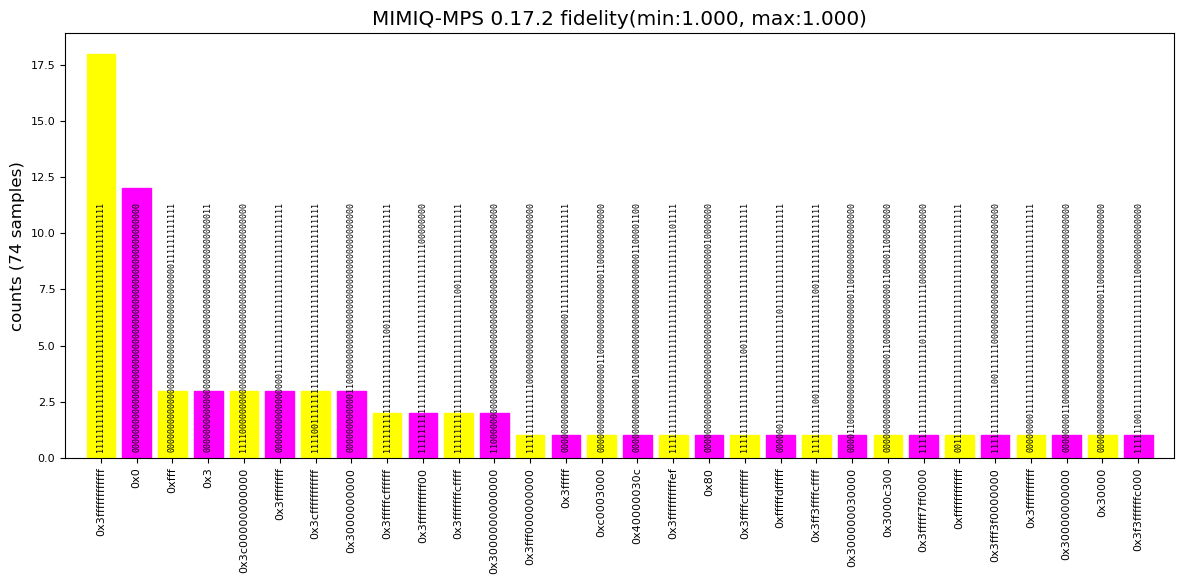

In [440]:
# build the circuit and add noise
circ = ghz_dynamic_circuit_with_idle(nqubits)
circ.add_noise(GateID(), Depolarizing1(noise_ampl))
circ.add_noise(GateCX(), Depolarizing2(noise_ampl))

# count the number of Kraus operators
nk = sum(isinstance(c.get_operation(), krauschannel) for c in circ)

# execute the simulation
job = conn.execute(circ, nsamples=nsamples, bonddim=4)
res = conn.get_result(job)

# output the results
print("Number of Kraus operators in circuit: ", nk)
plothistogram(res, num_outcomes=30, mimiqstyle=False)

The results are impressive! Using dynamic circuits provides another substantial improvement. We now sample the GHZ states approximately 50% of the time, with most remaining errors stemming from CNOT gates rather than idle errors.

## Summary and Conclusions

In this demo, we explored three different approaches to preparing GHZ states on quantum computers:
1. Linear depth circuit (traditional approach)
2. Logarithmic depth circuit ([Cruz et al., 2019](https://arxiv.org/abs/1807.05572))
3. Constant depth dynamic circuit ([Quek, Kaur, Wilde, 2022](https://arxiv.org/pdf/2206.15405), [Bäumer et al., 2024](https://arxiv.org/abs/2308.13065))

Using MIMIQ we could implement and analyze these circuits for a 50-qubit system under realistic noise conditions (all simulations were performed with fidelity 1). Our key findings reveal:
1. **Unitary Circuits**: We compared linear and logarithmic depth circuits. The logarithmic depth circuit significantly outperformed its linear counterpart by reducing idle-time errors. However, it still yielded only about 15% correct outcomes.
2. **Dynamic Circuits**: A constant depth implementation, leveraging mid-circuit measurements and classical feedback, demonstrated remarkably improved performance. This approach produced correct samples approximately 50% of the time, with remaining errors primarily stemming from CX gate imperfections rather than idle time.
3. **Fidelity assessment**: While sampling probabilities provide insights into the influence of noise and errors, they don't offer a complete picture of GHZ state fidelity, particularly regarding phase errors from depolarizing noise. For a more comprehensive analysis, we encourage you to try implementing the Parity Oscillation method to characterise the GHZ state preparation fidelity ([Cruz et al., 2019](https://arxiv.org/abs/1807.05572)).

For quantum computing practitioners: The choice of circuit implementation can dramatically impact the fidelity of quantum algorithms in noisy environments. Although relatively unexplored, dynamic circuits offer a promising approach for optimizing performance in the presence of noise. Quantum simulators like MIMIQ provide invaluable tools for testing and comparing circuit implementations at scales currently challenging for hardware, enabling deeper understanding and mitigation of noise effects in real-world quantum algorithm implementation.